## 


In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = 'drive/My Drive/TSECC_datathon2020'
# datas = pd.read_csv(os.path.join(path, "data/data_full_fillna_ori.csv"), encoding="utf-8")
# # drop the last 3 rows because no outcome label
# datas = datas[:-3]
# datas.drop(columns=['Unnamed: 0'], inplace=True)
# datas.to_csv(os.path.join(path, "data/data_full_fillna.csv"), encoding="utf-8", index=False)

In [3]:
path = 'drive/My Drive/TSECC_datathon2020'
datas = pd.read_csv(os.path.join(path, "data/data_full.csv"), encoding="utf-8")
# drop the last 3 rows because no outcome label
datas = datas[:-3]

In [4]:
datas.loc[datas['age'] > 91,'age'] = 91
datas['age'].value_counts()

91.000000    40752
43.208354     1127
58.221245     1033
27.066079      917
53.910612      877
             ...  
19.704060        4
66.826551        4
87.277255        3
84.968002        2
81.182024        1
Name: age, Length: 7852, dtype: int64

In [ ]:
# 補缺失值
# for col in s[s > 0].index:
#     most = datas[col].value_counts().idxmax()
#     datas[col] = datas[col].fillna(most)

# datas = datas.fillna(datas.mean())
# datas.isna().sum()

In [5]:
datas0 = datas[datas['outcome_3h_ahead'] == 0]
datas1 = datas[datas['outcome_3h_ahead'] == 1]

# data for train
datas_train = pd.concat([datas0.head(50000), datas1.head(50000)])
datas_y_train = datas_train['outcome_3h_ahead']
datas_24_x_train = datas_train.drop(['outcome_3h_ahead'], axis=1)
# 補缺失值
datas_24_x_train = datas_24_x_train.fillna(datas_24_x_train.mean())
#datas_15_x_train = datas_24_x_train.drop(['m_ap', 'plt', 'crtn', 'systolic_bp', 'diastolic_bp', 'bili_d', 'gcs', 'fio2', 'sofa'], axis=1)

# data for predict
datas_pred = pd.concat([datas0.tail(200), datas1.tail(200)])
datas_y_pred = datas_pred['outcome_3h_ahead']
datas_24_x_pred = datas_pred.drop(['outcome_3h_ahead'], axis=1)
# 補缺失值
datas_24_x_pred = datas_24_x_pred.fillna(datas_24_x_pred.mean())
#datas_15_x_pred = datas_24_x_pred.drop(['m_ap', 'plt', 'crtn', 'systolic_bp', 'diastolic_bp', 'bili_d', 'gcs', 'fio2', 'sofa'], axis=1)


In [6]:
# Normalization
scaler = MinMaxScaler()
datas_24_x_train = pd.DataFrame(scaler.fit_transform(datas_24_x_train), columns=datas_24_x_train.columns)
datas_15_x_train = datas_24_x_train.drop(['m_ap', 'plt', 'crtn', 'systolic_bp', 'diastolic_bp', 'bili_d', 'gcs', 'fio2', 'sofa'], axis=1)

# scaler = MinMaxScaler()
datas_24_x_pred = pd.DataFrame(scaler.fit_transform(datas_24_x_pred), columns=datas_24_x_pred.columns)
datas_15_x_pred = datas_24_x_pred.drop(['m_ap', 'plt', 'crtn', 'systolic_bp', 'diastolic_bp', 'bili_d', 'gcs', 'fio2', 'sofa'], axis=1)

In [7]:
# 切分訓練data
x_train_24, x_test_24, y_train_24, y_test_24 = train_test_split(np.array(datas_24_x_train), np.array(datas_y_train), test_size=0.2, random_state=0)
print(x_train_24.shape, x_test_24.shape, y_train_24.shape, y_test_24.shape)

x_train_15, x_test_15, y_train_15, y_test_15 = train_test_split(np.array(datas_15_x_train), np.array(datas_y_train), test_size=0.2, random_state=0)
print(x_train_15.shape, x_test_15.shape, y_train_15.shape, y_test_15.shape)

(80000, 24) (20000, 24) (80000,) (20000,)
(80000, 15) (20000, 15) (80000,) (20000,)


In [ ]:
y_train_24[:50]

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.])

In [ ]:
y_train_15[:50]

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.])

In [8]:
def build_mlp(input_shape, output_units=1, num_neurons=[4096, 512, 32], l1_p=1e-8, l2_p=1e-12, drp_ratio=0., BN=True):
    """
    建立神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_p, l2=l2_p))(input_layer)
            if BN == True:
                x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l1_l2(l1=l1_p, l2=l2_p))(x)
            if BN == True:
                x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="sigmoid", name="output")(x)
    #out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
"""
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 500
BATCH_SIZE = 256
MOMENTUM = 0.95

In [10]:
"""
設定 callbacks: Earlystop
"""
#earlystop = EarlyStopping(monitor="val_accuracy", patience=20, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
checkpoint = ModelCheckpoint(os.path.join(path,"sepsis_dnn_nosofa.h5"), save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [11]:
np.unique(y_train_15, return_counts=True)

(array([0., 1.]), array([39993, 40007]))

In [12]:
# 計算  class_weight
data_count = np.unique(y_train_15, return_counts=True)[1]
print(data_count)
num_classes=2
c_weights = (1/data_count)*np.sum(data_count)/num_classes
print(c_weights)
class_weight = {i: w for i, w in enumerate(c_weights)}
print('class_weight', class_weight)

[39993 40007]
[1.00017503 0.99982503]
class_weight {0: 1.0001750306303603, 1: 0.9998250306196416}


In [20]:
# 建立模型
model = build_mlp(input_shape=x_train_15.shape[1:], l1_p=1e-4, l2_p=1e-6, drp_ratio=0.3)
model.summary()
#optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)
#model.compile(loss="categorial_crossentropy", metrics=["accuracy"], optimizer=optimizer)

# load pre-trained model
# model = keras.models.load_model(os.path.join(path,"sepsis_dnn_nosofa.h5"))


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 4096)              65536     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 4096)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4096)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               2097664   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)              

In [14]:
y_test_15

array([0., 1., 1., ..., 0., 1., 1.])

In [ ]:

"""
訓練流程, 並將結果用 dictionary 紀錄
"""

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          class_weight = class_weight,
          callbacks=[checkpoint, earlystop, reduce_lr],
          verbose=2
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


Epoch 1/500
313/313 - 39s - loss: 1.6908 - accuracy: 0.5872 - val_loss: 0.9760 - val_accuracy: 0.5003
Epoch 2/500
313/313 - 40s - loss: 0.8399 - accuracy: 0.6264 - val_loss: 0.8435 - val_accuracy: 0.5585
Epoch 3/500
313/313 - 40s - loss: 0.7535 - accuracy: 0.6472 - val_loss: 0.8220 - val_accuracy: 0.5884
Epoch 4/500
313/313 - 39s - loss: 0.7253 - accuracy: 0.6593 - val_loss: 0.8408 - val_accuracy: 0.6037
Epoch 5/500
313/313 - 39s - loss: 0.7010 - accuracy: 0.6690 - val_loss: 0.9181 - val_accuracy: 0.5375
Epoch 6/500
313/313 - 40s - loss: 0.6849 - accuracy: 0.6770 - val_loss: 0.7572 - val_accuracy: 0.5533
Epoch 7/500
313/313 - 40s - loss: 0.6713 - accuracy: 0.6860 - val_loss: 0.7534 - val_accuracy: 0.6107
Epoch 8/500
313/313 - 39s - loss: 0.6629 - accuracy: 0.6924 - val_loss: 0.7822 - val_accuracy: 0.5870
Epoch 9/500
313/313 - 40s - loss: 0.6558 - accuracy: 0.6986 - val_loss: 0.7175 - val_accuracy: 0.6446
Epoch 10/500
313/313 - 39s - loss: 0.6511 - accuracy: 0.7034 - val_loss: 0.7382 - 

In [ ]:
history_df = pd.DataFrame(model.history.history)
with open(os.path.join(path,"dnn_nosofa_history.json"), mode='w') as f:
    history_df.to_json(f)

In [ ]:
len(train_loss), len(valid_loss), len(train_acc), len(valid_acc)

(169, 169, 169, 169)

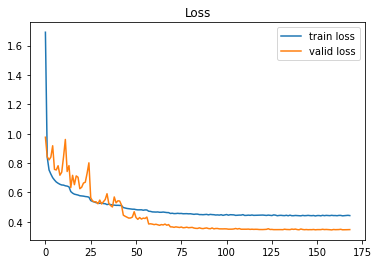

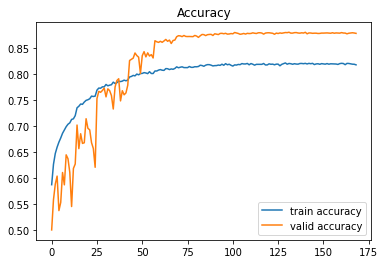

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
將結果繪出
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

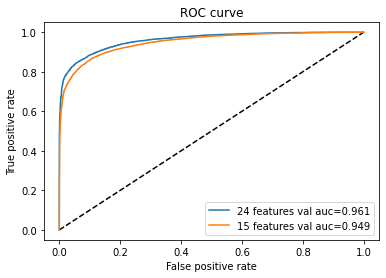

In [15]:
model_24 = keras.models.load_model(os.path.join(path,"sepsis_dnn.h5"))
model_15 = keras.models.load_model(os.path.join(path,"sepsis_dnn_nosofa.h5"))

# ROC curve
# pred_proba_train = model.predict(x_train)[:,0]
# fpr_trn, tpr_trn, _ = metrics.roc_curve(y_train, pred_proba_train)

pred_proba_24 = model_24.predict(x_test_24)[:,0]
fpr_24, tpr_24, _ = metrics.roc_curve(y_test_24, pred_proba_24)
pred_proba_15 = model_15.predict(x_test_15)[:,0]
fpr_15, tpr_15, _ = metrics.roc_curve(y_test_15, pred_proba_15)

# auc score 
# auc_train = metrics.roc_auc_score(y_train, pred_proba_train)
auc_test_24 = metrics.roc_auc_score(y_test_24, pred_proba_24)
auc_test_15 = metrics.roc_auc_score(y_test_15, pred_proba_15)
# print("AUC of: train={} test={} ".format(auc_train, auc_test))

# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_trn, tpr_trn, label='trn auc={:.3f}'.format(auc_train))
plt.plot(fpr_24, tpr_24, label='24 features val auc={:.3f}'.format(auc_test_24))
plt.plot(fpr_15, tpr_15, label='15 features val auc={:.3f}'.format(auc_test_15))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [16]:
model_15.predict(x_test_15)[:,0]

array([0.17240283, 0.8884058 , 0.8643689 , ..., 0.02526444, 0.7268961 ,
       0.5313075 ], dtype=float32)

In [17]:
y_pre = model_15.predict(np.array(x_test_15))[:,0] > 0.5
y_pre

array([False,  True,  True, ..., False,  True,  True])

In [18]:
from sklearn.metrics import classification_report

target_names = [str(i) for i in range(2)]
print("classification_report:\n", classification_report(np.array(y_test_15), np.array(y_pre), target_names=target_names))

classification_report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     10007
           1       0.91      0.84      0.87      9993

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



In [19]:
pd.DataFrame(metrics.confusion_matrix(np.array(y_test_15), np.array(y_pre)),
            index=["{}(真實)".format(i) for i in range(2)],
            columns=["{}(預測)".format(i) for i in range(2)] 
            )

,0(預測),1(預測)
0(真實),9198,809
1(真實),1617,8376


In [ ]:
# ! pip install eli5

In [ ]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(model, random_state=0).fit(x_test, y_test)
# eli5.show_weights(perm, feature_names = x_test.columns.tolist())

In [ ]:
! pip install shap

     |████████████████████████████████| 327kB 5.2MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463905 sha256=037145ab4041609a5057f2ac518358fd9877f624e183dc6b990ef56bfb0db385
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
import sklearn
import shap

# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, shap.sample(x_train, 2))
x_train_df = pd.DataFrame(x_train, columns=datas.columns)
shap_values = explainer.shap_values(x_train_df, nsamples=100)


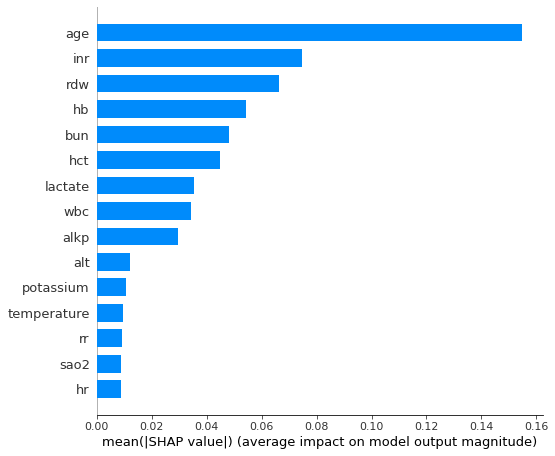

In [ ]:
# plot the SHAP values for the Setosa output of the first instance
#  shap.force_plot(explainer.expected_value[0], shap_values[0], data_pred_x, link="logit")
shap.summary_plot(shap_values[0], x_train_df, plot_type="bar")

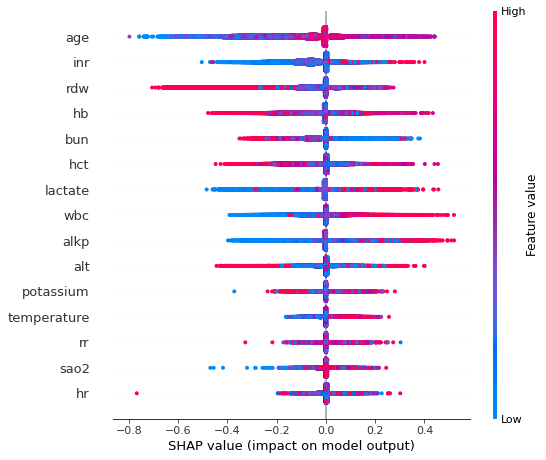

In [ ]:
shap.summary_plot(shap_values[0], x_train_df)

In [ ]:
shap_values[0].shape

(80000, 15)